# Exploratory Spatial Data Analysis

Intro blah blah

In [93]:
%matplotlib inline

import seaborn as sns
import pandas as pd
import pysal as ps
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

## Data

In [94]:
js_path = '../../../../data/john_snow/'

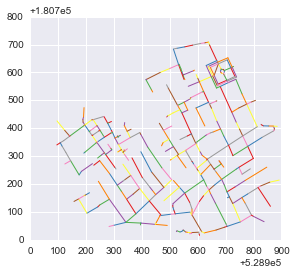

In [95]:
pumps = gpd.read_file(js_path+'Pumps.shp')
js = gpd.read_file(js_path+'streets_js.shp')
js.plot(colormap='Set1')

In [96]:
js.head()

,Deaths,geometry,segIdStr
0,0,"LINESTRING (529604.7890700001 180871.77665, 52...",s0-1
1,0,"LINESTRING (529604.7890700001 180871.77665, 52...",s0-217
2,0,"LINESTRING (529604.7890700001 180871.77665, 52...",s0-223
3,0,"LINESTRING (529634.06935 180889.85896, 529670....",s1-2
4,0,"LINESTRING (529670.07711 180912.81968, 529747....",s2-3


Spatial weights matrix for street network:

In [97]:
ntw = ps.Network(js_path+'streets_js.shp')
w = ntw.contiguityweights(graph=False)
w.remap_ids(js['segIdStr'])
w.transform = 'R'

Spatial lag:

In [98]:
js['w_Deaths'] = ps.lag_spatial(w, js['Deaths'])

Standardized death count:

In [99]:
js['Deaths_std'] = (js['Deaths'] - js['Deaths'].mean()) / js['Deaths'].std()

Spatial lag of standardized death count:

In [100]:
js['w_Deaths_std'] = ps.lag_spatial(w, js['Deaths_std'])

## Global Spatial autocorrelation

* Moran Plot

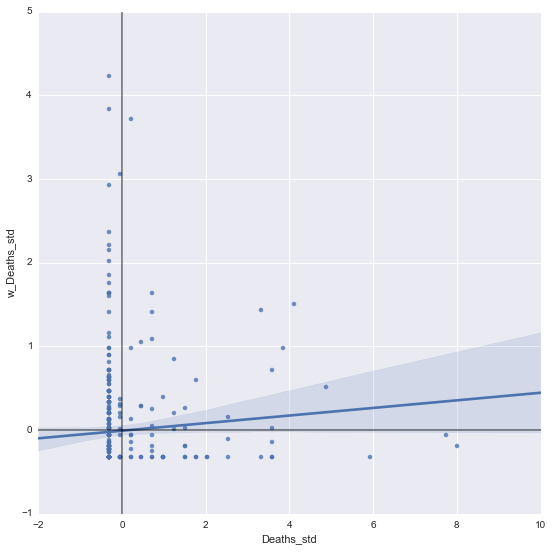

In [101]:
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot values
sns.regplot(x='Deaths_std', y='w_Deaths_std', data=js)
# Add vertical and horizontal lines
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
# Display
plt.show()

* Moran's I

In [102]:
mi = ps.Moran(js['Deaths'], w)

In [103]:
mi.I

0.045378623340909745

* Inference on Moran's I (seaborn band)

In [104]:
mi.p_sim

0.13500000000000001

## Local Spatial autocorrelation

* Moran Plot and Quadrants

* LISAs

In [105]:
lisa = ps.Moran_Local(js['Deaths'].values, w)

In [106]:
js['significant'] = lisa.p_sim < 0.05
js['quadrant'] = lisa.q

From `PySAL` documentation:
* 1 HH
* 2 LH
* 3 LL
* 4 HL

* LISA cluster maps

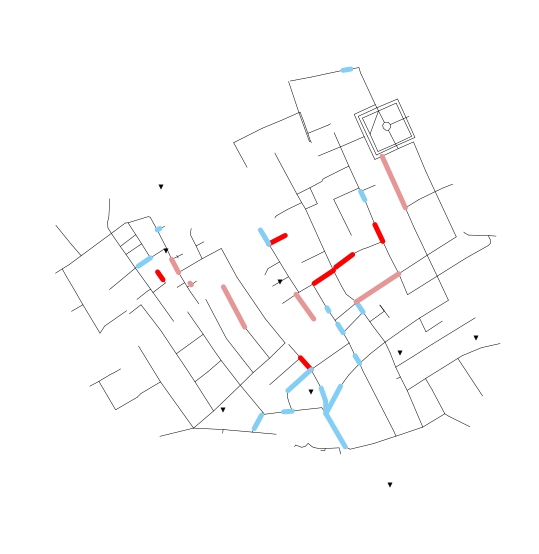

In [122]:
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot baseline street network
for line in js['geometry']:
    gpd.plotting.plot_multilinestring(ax, line, color='k', linewidth=0.5)
# Plot HH clusters
hh = js.loc[(js['quadrant']==1) & (js['significant']==True), 'geometry']
for line in hh:
    gpd.plotting.plot_multilinestring(ax, line, color='red', linewidth=5)
# Plot LL clusters
ll = js.loc[(js['quadrant']==3) & (js['significant']==True), 'geometry']
for line in ll:
    gpd.plotting.plot_multilinestring(ax, line, color='blue', linewidth=5)
# Plot LH clusters
lh = js.loc[(js['quadrant']==2) & (js['significant']==True), 'geometry']
for line in lh:
    gpd.plotting.plot_multilinestring(ax, line, color='#83cef4', linewidth=5)
# Plot HL clusters
hl = js.loc[(js['quadrant']==4) & (js['significant']==True), 'geometry']
for line in hl:
    gpd.plotting.plot_multilinestring(ax, line, color='#e59696', linewidth=5)
# Plot pumps
xys = np.array([(pt.x, pt.y) for pt in pumps.geometry])
ax.scatter(xys[:, 0], xys[:, 1], marker='v', color='k')
# Style and draw
ax.set_axis_off()
plt.axis('equal')
plt.show()

## Main exercise

* Use IMD data for Liverpool and perform the same analysis

## `[Extension]` Spatial autocorrelation interactive visualization

---

<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" /></a><br /><span xmlns:dct="http://purl.org/dc/terms/" property="dct:title">Geographic Data Science'15 - Lab 6</span> by <a xmlns:cc="http://creativecommons.org/ns#" href="http://darribas.org" property="cc:attributionName" rel="cc:attributionURL">Dani Arribas-Bel</a> is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>.

